**2a.**
Read the grayscale image brain-noisy.png and the brain mask mask.png, which are provided
along with this sheet on eCampus. Reduce the salt and pepper noise in the image using a median
filter. (1P)
Hint: You do not have to implement the median filter yourself, you may use a suitable Python
package.

**2b.**
Plot a log-scaled histogram of the pixels within the brain mask. It should show how frequently
different intensity values occur in the image. Based on this histogram, what are approximate
intensity ranges for cerebrospinal fluid, gray matter, or white matter? What are their approximate
mixing weights? (2P)

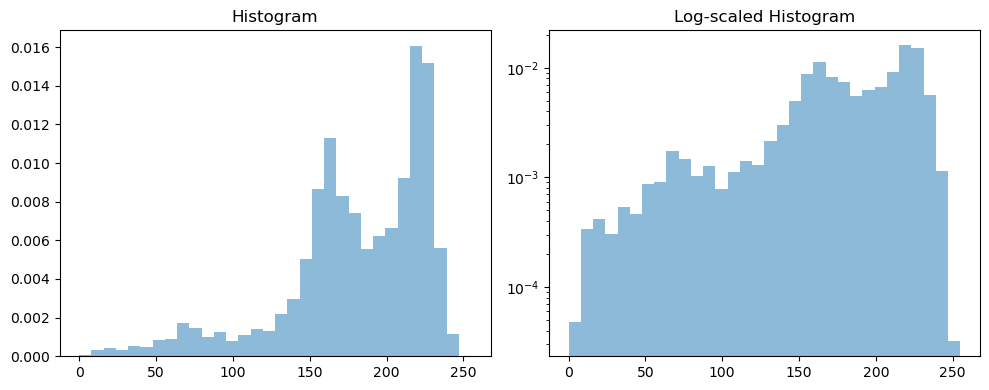


                            Peak (**)   Intensity range     Mixing weight (*)
CSF (cerebrospinal fluid):  75          20 - 100            0.14
Gray matter:                160         100 - 175           0.37
White matter:               225         175 - 255           0.49

* Mixing weights are estimated by 'peak x intensity range' and afterwards normalized.
** Peaks are extracted from the non-log histogram.



In [101]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

mask_file = 'mask.png'
img_file = 'brain-noisy.png'

mask = cv2.imread(mask_file, cv2.IMREAD_GRAYSCALE)
img = cv2.imread(img_file, cv2.IMREAD_GRAYSCALE)

# kernel size of 5 produced the best result
img_filt = cv2.medianBlur(img, ksize=5)

mask = (mask>0).astype(np.uint8)

hist_range = [0,255]
hist_bins = 32
hist_pixels = img_filt[mask > 0].astype(np.float32)

# cv2.imshow('Filtering Step', cv2.hconcat([img, img_filt, img_hist]))
# cv2.waitKey(0)
# cv2.destroyAllWindows()

# Plotting histograms
fig, axes = plt.subplots(1, 2, figsize=(10, 4))
axes[0].hist(
    x=hist_pixels,
    bins = hist_bins,
    range=hist_range,
    density=True,
    alpha=0.5,
    log=False
)
axes[0].set_title("Histogram")
axes[1].hist(
    x=hist_pixels,
    bins = hist_bins,
    range=hist_range,
    density=True,
    alpha=0.5,
    log=True
)
axes[1].set_title("Log-scaled Histogram")

plt.tight_layout()
plt.show()


output = f"""
                            Peak (**)   Intensity range     Mixing weight (*)
CSF (cerebrospinal fluid):  75          20 - 100            0.14
Gray matter:                160         100 - 175           0.37
White matter:               225         175 - 255           0.49

* Mixing weights are estimated by 'peak x intensity range' and afterwards normalized.
** Peaks are extracted from the non-log histogram.
"""
print(output)


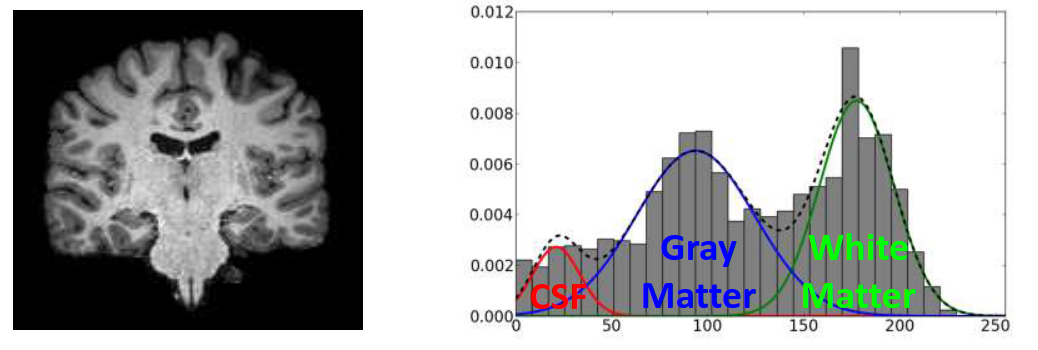

**2c.** Now, we will use a three-compartment Gaussian Mixture Model (GMM) for image segmentation:
Based on the histogram from b), find a plausible initialization of the GMM parameters. Use them
to compute the responsibilities ρik of cluster k for pixel i. (2P)

**2d.** Visualize the responsibilities by mapping the probabilities of belonging to the CSF, gray matter,
and white matter clusters to the red, blue, and green color channels, respectively. Please submit
the resulting image. (1P)

In [ ]:
# Implementation of gaussian mixture model with EM-algorithm and clustering for MR imaging

from scipy.stats import norm

class GMM:
    
    def __init__(self, mix_coeff: np.ndarray, sigma: np.ndarray, mean: np.ndarray, n: int, k: int):
        self.k = k 
        self.n = n 
        self.sigma = sigma                  # sigma: k
        self.mean = mean                    # mean: k 
        self.mix_coeff = mix_coeff          # mixture coefficents: k 
        self.prob = np.zeros(shape=(n,k))   # probabilites: n x k
    
    # Helper function to compute gaussians    
    def gaussian(self, x, mean, sigma):
        return norm.pdf(x, loc=mean, scale=sigma)

    # Expectation step (first step of EM-Algorithm)
    def e_step(self, data: np.ndarray):
        data = data.astype(np.float32)
        K = self.k         
        N = len(data)
        prob = np.zeros((N, K), dtype=np.float32)
        
        for k in range(K):
            prob[:, k] = self.gaussian(data, self.mean[k], self.sigma[k]) * self.mix_coeff[k]
        denom = prob.sum(axis=1, keepdims=True)
        self.prob = prob / denom
        self.n = N
    
    # Maximization step (second step of EM-Algorithm)
    def m_step(self, data: np.ndarray):
        data = data.astype(np.float32)
        K = self.k 
        
        # Effective number
        N_k = np.sum(self.prob, axis=0)
        
        # Mixture coefficents
        mix_coeff = N_k / self.n
        
        # Mean
        mean = self.prob * data[:, None]
        mean = np.sum(mean, axis=0)        
        mean /= N_k
        
        # Sigma
        diff2 = (np.outer(data, np.ones(K)) - np.outer(np.ones_like(data), mean))**2   
        sigma2 = self.prob * diff2 
        sigma2 = np.sum(sigma2, axis=0)
        sigma2 /= N_k
        sigma = np.sqrt(sigma2)
                
        # Update 
        self.sigma = sigma
        self.mean = mean   
        self.mix_coeff = mix_coeff            
    
    # Run EM-Algorithm for given number of iterations
    def run_em_algo(self, data: np.ndarray, max_iters: int):
        for _ in range(max_iters):
            self.e_step(data)
            self.m_step(data)
    
    # Predict probability for new data point
    def predict(self, data: float):
        data = data.astype(np.float32)
        prob = np.zeros(self.k)
        K = self.k
        for k in range(K):
            mean = self.mean[k]
            sigma = self.sigma[k]
            mix_coeff = self.mix_coeff[k]
            prob[k] = self.gaussian(x=data, mean=mean, sigma=sigma) * mix_coeff
        sum = np.sum(prob, axis=0)
        prob /= sum
        return prob
    
    
    # Clustering for given image and mask, return segmented image
    def viz(self, img: np.ndarray, mask: np.ndarray, discrete_labeling = False):
        segmented_img = np.zeros(shape=np.hstack([img.shape,3]), dtype=np.uint8)
        for y in np.arange(img.shape[0]):
            for x in np.arange(img.shape[1]):
                if mask[y,x] > 0:
                    data_x = img[y,x]
                    prob = self.predict(data_x)
                    prob2 = np.array([prob[1], prob[2], prob[0]])
                    if discrete_labeling:
                        label_idx = np.argmax(prob2)
                        prob2 = np.zeros_like(prob2)
                        prob2[label_idx] = 1.0
                    segmented_img[y,x] = (255*prob2).astype(np.uint8)
        return segmented_img
    

In [103]:
# Initialization GMM parameters
data = img_filt[mask > 0].astype(np.float32)
sigma = np.array([20,19,20])
mean = np.array([75, 160, 225])
mix_coeff = np.array([0.14, 0.37, 0.49])

# Compute probabilites + clustering + segmented image with based on intial parameter set
gmm = GMM(mix_coeff, sigma, mean, len(data), len(mix_coeff))
segmented_img_1 = gmm.viz(img_filt, mask)
cv2.imshow('Segmented Image with initial parameters', segmented_img_1)
cv2.waitKey(0)
cv2.destroyAllWindows()   
cv2.imwrite('task2_segmented_image_initial.png', segmented_img_1)


True

**Image: Initial GMM Output with probabilistic Labeling**

File: task2_segmented_image_initial.png

![task2_segmented_image_initial.png](task2_segmented_image_initial.png)

**2e.** Use the update rules provided in the lecture to re-compute the parameters μk, σk, and πk. (1P)

**2f.** Iterate the E and M steps of the algorithm until convergence. Please submit the final parameter
values, a visualization of the final responsibilities, and your code. Remember to constrain your
algorithm to the brain mask. (2P)

Means:   [ 79.23608 170.44414 221.6606 ]
Sigmas:  [32.68607618 21.27901342  9.54530467]
Weights: [0.10700924 0.5048433  0.388146  ]


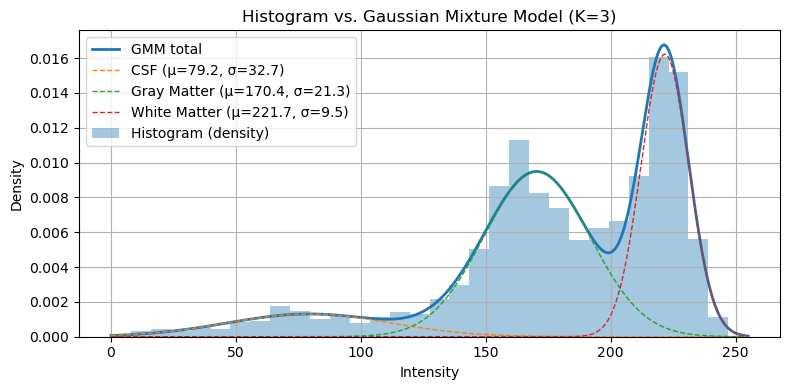

In [104]:
# Initialization GMM with same parameters but this time run EM-algorithm for 100 iterations
gmm2 = GMM(mix_coeff, sigma, mean, len(data), len(mix_coeff))
iters = 1000
gmm2.run_em_algo(data, iters)

# Compute probabilites + clustering + segmented image with based on intial parameter set
segmented_img_2 = gmm2.viz(img_filt, mask)
cv2.imshow('Segmented Image after 100 iterations of EM', segmented_img_2)
cv2.waitKey(0)
cv2.destroyAllWindows()   
cv2.imwrite('task2_segmented_image_EM.png', segmented_img_2)

# Plotting histogram and GMM results with its component
means  = gmm2.mean         
sigmas  = gmm2.sigma             
weights = gmm2.mix_coeff                 
print("Means:  ", means)
print("Sigmas: ", sigmas)
print("Weights:", weights)

# Plotting
pixels = data.copy()
counts, bin_edges = np.histogram(
    pixels,
    bins=32,
    range=(0, 255),
    density=True
)
bin_centers = 0.5 * (bin_edges[:-1] + bin_edges[1:])

# feine x-Achse für glatte PDF
x = np.linspace(0, 255, 500)


def gaussian(x, mu, sigma):
    return (1.0 / (np.sqrt(2 * np.pi) * sigma)) * np.exp(-0.5 * ((x - mu) / sigma) ** 2)

component_pdfs = []
for w, m, s in zip(weights, means, sigmas):
    component_pdfs.append(w * gaussian(x, m, s))

gmm_pdf = np.sum(component_pdfs, axis=0)

plt.figure(figsize=(8,4))

# Histogramm
plt.bar(bin_centers, counts,
        width=(bin_edges[1] - bin_edges[0]),
        alpha=0.4, align="center", label="Histogram (density)")

# GMM
plt.plot(x, gmm_pdf, linewidth=2, label="GMM total")

# Gaussians components
labels = ['CSF', 'Gray Matter', 'White Matter']
for k, comp in enumerate(component_pdfs):
    plt.plot(x, comp, linestyle="--", linewidth=1,
            label=f"{labels[k]} (μ={means[k]:.1f}, σ={sigmas[k]:.1f})")

plt.xlabel("Intensity")
plt.ylabel("Density")
plt.title("Histogram vs. Gaussian Mixture Model (K=3)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

**Image: Final GMM Output with probabilistic Labeling after 1000 iterations of EM-Algorithm**

File: task2_segmented_image_EM.png

![task2_segmented_image_EM.png](task2_segmented_image_EM.png)